In [2]:
using LinearAlgebra, Plots, Random, Distributions

In [4]:
# structural_params = [alpha, beta, lambda, benefits, beta_hat]
Params = Vector{Float64}([0.0009, 0.995, 0.009, 0.1, 0.9941045])
# grid_sizes = [hc_grid_size, search_grid_size, wage_grid_size]
Sizes = Vector{Int64}([201, 41, 41])
# grid_bounds = [hc_min, hc_max, search_min, search_max, wage_min, wage_max]
Bounds = Vector{Float64}([1.0, 2.0, 0.0, 1.0, 0.0, 1.0])
# human_capital_losses = [unemployment_loss, job_loss]
Losses = Vector{Int64}([10, 30])

2-element Vector{Int64}:
 10
 30

In [5]:
function search_grid(S,B)

    grid = range(B[3], stop=B[4], length=S[2])

    return grid

end

search_grid (generic function with 1 method)

In [146]:
function wage_grid(S,B)

    grid = range(B[5], stop=B[6], length=S[3])

    lower, upper = 0, 1

    dist = Normal(0.5, 0.1)

    truncated_dist = Truncated(dist, lower, upper)
    # Compute the probability density function at each point in the wage grid
    pdf_values = [pdf(truncated_dist, point) for point in grid]
    # Normalize the probabilities so they sum to 1
    probs = pdf_values / sum(pdf_values)

    return grid, probs

end

wage_grid (generic function with 1 method)

In [147]:
w_grid, w_probs = wage_grid(Sizes, Bounds)
display(size(w_probs))

(41,)

In [8]:
function human_capital_grid(S,B)

    grid = range(B[1], stop=B[2], length=S[1])

    return grid

end

human_capital_grid (generic function with 1 method)

In [9]:
function initial_value_functions(S)

    U = zeros(S[1], 1)

    W = zeros(S[1], S[2])

    return U, W

end

initial_value_functions (generic function with 1 method)

In [10]:
function cost_of_search(S,B)

    grid = search_grid(S,B)

    cost = (1/2) .* grid 

    return cost

end

cost_of_search (generic function with 1 method)

In [11]:
function contact_probability(S,B)

    grid = search_grid(S,B)

    contact_probs = grid .^ (0.3)

    return contact_probs

end

contact_probability (generic function with 1 method)

Work on Bellman iteration here

In [166]:
function Bellman(B, L, S, P, tolerance, max_iterations, tau)

    U_0, W_0 = initial_value_functions(S)

    U_1, W_1 = similar(U_0), similar(W_0)

    store_U_values = zeros(S[2], S[3])

    hc_grid = human_capital_grid(S,B)

    s_grid = search_grid(S,B)

    w_grid, w_probs = wage_grid(S,B)

    cost = cost_of_search(S,B)

    contact_probs = contact_probability(S,B)

    error = tolerance + 1

    iter = 1

    min_hc, max_hc = minimum(hc_grid), maximum(hc_grid)

    b = P[4]

    unemployment_loss, job_loss = L[1], L[2]

    hc_tomorrow_unemp = 0

    if iter == 0 

        println("Iterating...")

    end

    while error > tolerance

        for i in 1:S[1]

            if i <= 11

                hc_tomorrow_unemp = min_hc

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                U_1[i,1] = maximum(store_U_values * w_probs)

            else

                hc_tomorrow_unemp = hc_grid[i-10]

                index = findfirst(isequal(hc_tomorrow_unemp), hc_grid)

                for k in 1:S[2]

                    for j in 1:S[3]

                        wage_index = findfirst(isequal(w_grid[j]), w_grid)

                        acceptance_value, rejection_value = W_0[index, wage_index], U_0[index]

                        max_value = max(acceptance_value, rejection_value)

                        store_U_values[k,j] = ((1-tau)*b) - cost[k] + ((P[5] * contact_probs[k]) * max_value) + ((P[5] * (1 - contact_probs[k])) * rejection_value)

                    end

                end

                U_1[i,1] = maximum(store_U_values * w_probs)

            end

            for i in 1:S[1]

                if i <= 11

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i+1,j]) + ((P[5] * (1 - P[4]) * U_1[1,1]))

                    end

                elseif i > 11 && i < S[1] 

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i+1,j]) + ((P[5] * (1 - P[4]) * U_1[i-10,1]))

                    end

                else 

                    for j in 1:S[2]

                        W_1[i,j] = (1-tau)*w_grid[j]*hc_grid[i] + (P[5] * P[4] * W_0[i,j]) + ((P[5] * (1 - P[4]) * U_1[i-10,1]))

                    end

                end

            end

        end

        error_unemp = maximum(abs.(U_1 - U_0))

        error_emp = maximum(abs.(W_1 - W_0))

        error = max(error_unemp, error_emp)

        if iter % 25 == 0

            println("Iteration: ", iter, " Error: ", error)

        end

        U_0, W_0 = copy(U_1), copy(W_1)

        iter += 1
    
    end

    display(plot(U_1, title = "Plot of U_1", xlabel = "Index", ylabel = "Value", legend = false))

    plot(W_1[:,1], title = "Plot of W_1 columns", xlabel = "Index", ylabel = "Value", legend = false)

    for j in 2:size(W_1, 2)
        plot!(W_1[:,j])
    end

    display(plot!())

    return W_1, U_1

end

Bellman (generic function with 1 method)

Iteration: 25 Error: 0.22593309681778972
Iteration: 50 Error: 0.18040048023009447
Iteration: 75 Error: 0.14441509214336712
Iteration: 100 Error: 0.11560829809454987
Iteration: 125 Error: 0.09283239683609423
Iteration: 150 Error: 0.07465755195321577
Iteration: 175 Error: 0.06004120957975445
Iteration: 200 Error: 0.04828658235722472
Iteration: 225 Error: 0.03883441803458254
Iteration: 250 Error: 0.031232527758877637
Iteration: 275 Error: 0.025118717868778617
Iteration: 300 Error: 0.020201694600018527
Iteration: 325 Error: 0.01624718533980385
Iteration: 350 Error: 0.013128369643364834
Iteration: 375 Error: 0.010616872905220731
Iteration: 400 Error: 0.008586406562095306
Iteration: 425 Error: 0.006944274319739208
Iteration: 450 Error: 0.005616196423858355
Iteration: 475 Error: 0.0045421106395018285
Iteration: 500 Error: 0.003673441508180275
Iteration: 525 Error: 0.0029709035259273264
Iteration: 550 Error: 0.0024027244589852614
Iteration: 575 Error: 0.0019432084466544097
Iteration: 600 Error

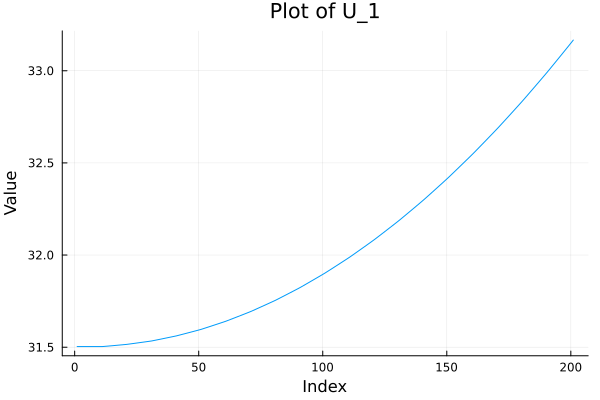

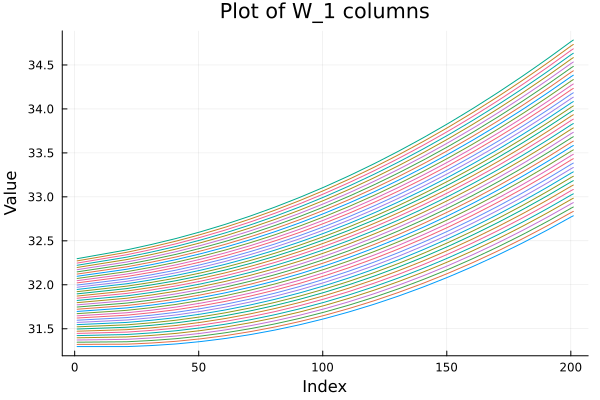

([31.296934280604233 31.32193170387176 … 32.27183378803761 32.29683121130514; 31.296934280604233 31.322056622043416 … 32.27670559673226 32.30182793817144; … ; 32.77003041614511 32.81988518480818 … 34.7143663940047 34.76422116266776; 32.784407951385276 32.834375220048344 … 34.733131429244864 34.783098697907924], [31.50327218700103; 31.50327218700103; … ; 33.14947409964994; 33.16643451270507;;])

In [168]:
out = Bellman(Bounds, Losses, Sizes, Params, 1e-3, 1000, 0.1)